In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn lightgbm kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d avinemmatty/theft-data
!unzip theft-data.zip

Dataset URL: https://www.kaggle.com/datasets/avinemmatty/theft-data
License(s): unknown
 84% 4.00M/4.79M [00:01<00:00, 4.43MB/s]
100% 4.79M/4.79M [00:01<00:00, 3.74MB/s]
Archive:  theft-data.zip
  inflating: Electricity_Theft_Data.csv  


In [49]:
import pandas as pd

# Load the dataset
data = pd.read_csv("Electricity_Theft_Data.csv")  # Replace with the correct file name
print(data.head())
print(data.info())

        CONS_NO  01-01-15  02-01-15  03-01-15  04-01-15  05-01-15  06-01-15  \
0           NaN      1.00      2.00      3.00      4.00      5.00      6.00   
1  8.546920e+09      0.00      0.00      0.00      0.00      0.00      0.00   
2  6.177183e+08      1.12      1.73      3.34      2.77      3.50      2.86   
3  7.222500e+09       NaN       NaN       NaN       NaN       NaN       NaN   
4  7.134080e+09      1.58      3.65      2.54      4.28      1.62      1.39   

   07-01-15  08-01-15  09-01-15  ...  23-12-15  24-12-15  25-12-15  26-12-15  \
0      7.00      8.00      9.00  ...    357.00    358.00    359.00    360.00   
1      0.00      0.00      0.00  ...      0.00      0.00      0.00      0.00   
2      1.25      1.12      1.51  ...     17.31     15.95     17.00     32.05   
3       NaN       NaN       NaN  ...      0.00      0.00      0.00      0.00   
4      2.33      1.78      1.80  ...      4.17      7.95      8.84      2.20   

   27-12-15  28-12-15  29-12-15  30-12-15  3

# Import required libraries

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# Step 1: Load the Dataset


In [51]:
def optimize_dataframe(df):
    """Optimize memory usage by downcasting numeric columns and converting objects to categories."""
    for col in df.select_dtypes(include=['float']):
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']):
        if df[col].nunique() / len(df) < 0.5:  # Convert likely categorical columns
            df[col] = df[col].astype('category')
    return df

# Load dataset in chunks and optimize memory usage
dataset_path = 'Electricity_Theft_Data.csv'  # Replace with your file path
chunk_size = 10000
chunks = []

for chunk in pd.read_csv(dataset_path, chunksize=chunk_size):
    optimized_chunk = optimize_dataframe(chunk)
    chunks.append(optimized_chunk)

# Combine all chunks into a single DataFrame
data = pd.concat(chunks, ignore_index=True)

# Display the memory usage after optimization
print(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Columns: 367 entries, CONS_NO to CHK_STATE
dtypes: float32(356), float64(11)
memory usage: 14.4 MB
None


# Step 2: Data Preprocessing


In [46]:
dataset.fillna(0, inplace=True)

# Convert CHK_STATE to categorical
dataset['CHK_STATE'] = dataset['CHK_STATE'].astype('category')

# Drop unnecessary columns if present
if 'CONS_NO' in dataset.columns:
    dataset.drop(['CONS_NO'], axis=1, inplace=True)

# Split features and target
X = dataset.drop(['CHK_STATE'], axis=1)
y = dataset['CHK_STATE'].astype('int')

# Step 3: Data Visualization (Class Distribution)

<ipython-input-47-5b401cf37007>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


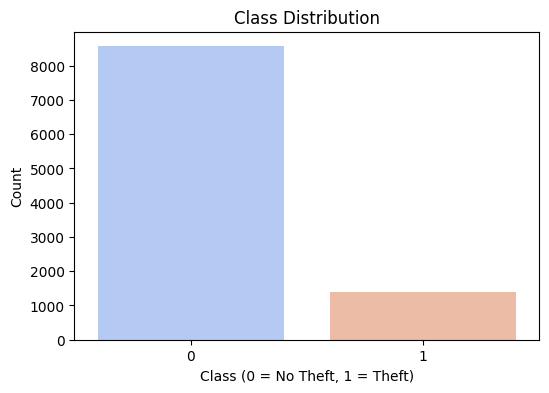

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class (0 = No Theft, 1 = Theft)")
plt.ylabel("Count")
plt.show()

# Step 4: Handle Class Imbalance with SMOTE


In [48]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Train-Test Split


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)

# Step 6: Hyperparameter Tuning for LightGBM


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9],
    'num_leaves': [20, 31, 40]
}

random_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(
        boosting_type='gbdt',
        objective='binary',
        random_state=42,
        # device_type='gpu'  # Enable GPU acceleration
    ),
    param_distributions=param_grid,
    scoring='roc_auc',
    n_iter=10,  # Number of combinations to test
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Run RandomizedSearchCV
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Step 7: Make Predictions and Evaluate

In [54]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(report)

Accuracy: 0.9402491241728299
ROC-AUC Score: 0.9826206684631021
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2574
           1       0.93      0.95      0.94      2564

    accuracy                           0.94      5138
   macro avg       0.94      0.94      0.94      5138
weighted avg       0.94      0.94      0.94      5138



# Step 8: Data Visualization (Feature Importance)

<ipython-input-55-19e5d4cc6d28>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette="viridis")


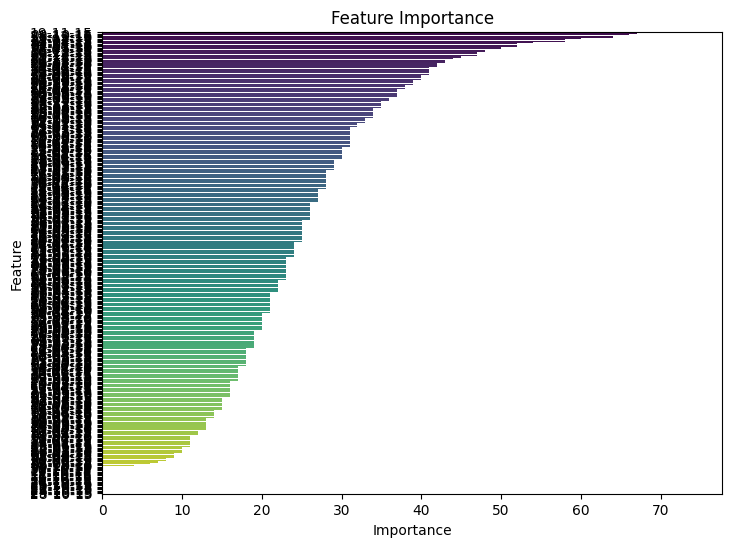

In [55]:
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance, palette="viridis")
plt.title("Feature Importance")
plt.show()

# Step 9: ROC Curve


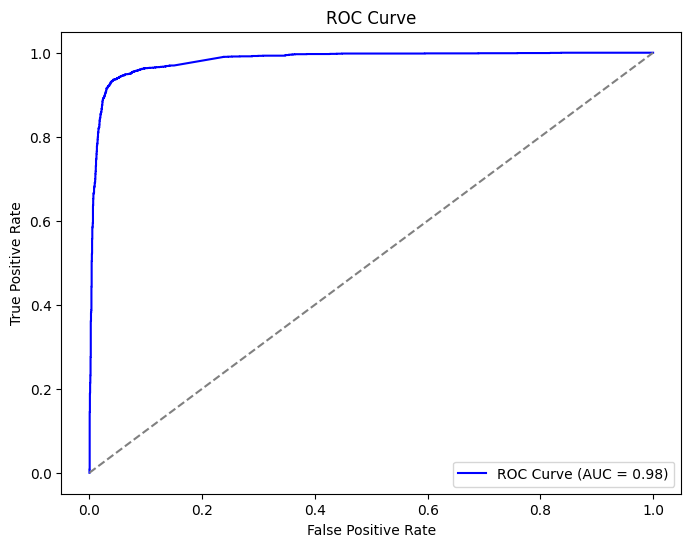

In [56]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Step 10: Identify Theft Cases


In [57]:
theft_cases = X_test[y_pred == 1].copy()
theft_cases['Prediction_Probability'] = y_pred_proba[y_pred == 1]

# Save theft cases to a CSV file
theft_cases.to_csv('detected_theft_cases.csv', index=False)

print("Theft cases have been saved to 'detected_theft_cases.csv'")

Theft cases have been saved to 'detected_theft_cases.csv'
